<a href="https://colab.research.google.com/github/manuuconrad/60_day_law_colorectal_brazil/blob/main/CCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-394210966.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentual_Atraso', y='UF', data=analise, palette='Reds_r')


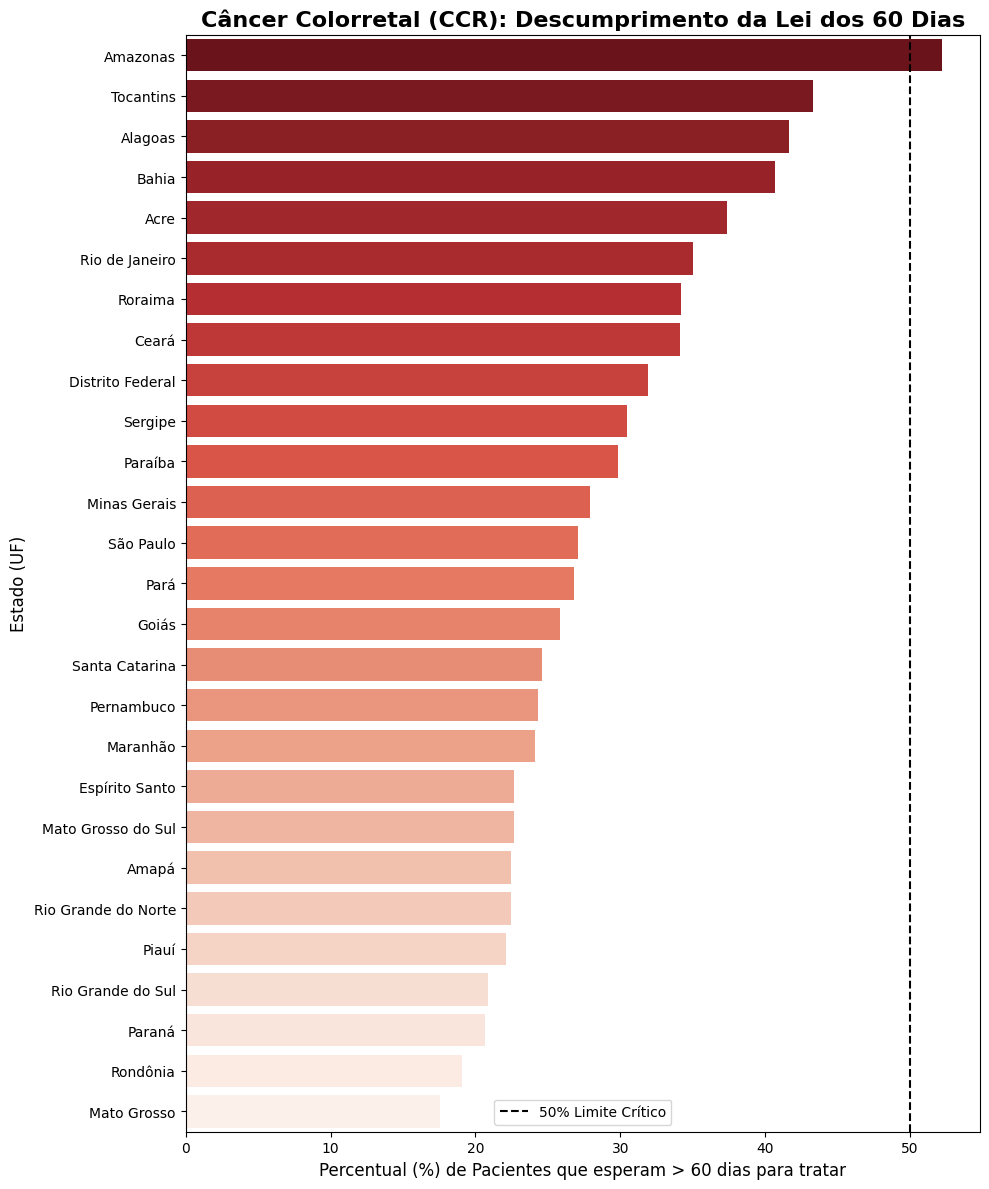

Análise concluída com sucesso!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Função para limpar os nomes das UFs (remove o código numérico '11 ', '12 ', etc)
def clean_uf(name):
    if pd.isna(name): return name
    return re.sub(r'^\d+\s+', '', str(name)).strip()

# 1. Carregar os arquivos reais que você subiu
# Removendo o 'skiprows=3' para evitar o erro de KeyError
df_total = pd.read_csv('PAINEL_ONCOLOGIABR17697831477.csv', sep=';', encoding='latin1')
df_atraso = pd.read_csv('PAINEL_ONCOLOGIABR17697830139.csv', sep=';', encoding='latin1')
df_estadiamento = pd.read_csv('PAINEL_ONCOLOGIABR17697830524.csv', sep=';', encoding='latin1')

# 2. Renomear colunas para facilitar (O DATASUS usa nomes com espaços)
df_total.columns = ['UF_Raw', '2023', '2024', '2025', 'Total_Casos']
df_atraso.columns = ['UF_Raw', '2023', '2024', '2025', 'Total_Atrasados']

# 3. Limpar nomes das UFs e remover a linha de 'Total' do final
for df in [df_total, df_atraso]:
    df['UF'] = df['UF_Raw'].apply(clean_uf)

# Remover linhas que contenham 'Total' na coluna UF
df_total = df_total[~df_total['UF'].str.contains('Total', case=False, na=False)]
df_atraso = df_atraso[~df_atraso['UF'].str.contains('Total', case=False, na=False)]

# 4. Unir os dados para calcular a % de descumprimento
analise = pd.merge(df_total[['UF', 'Total_Casos']],
                   df_atraso[['UF', 'Total_Atrasados']], on='UF')

# Converter para número (garantir que não haja erros de texto)
analise['Total_Casos'] = pd.to_numeric(analise['Total_Casos'], errors='coerce')
analise['Total_Atrasados'] = pd.to_numeric(analise['Total_Atrasados'], errors='coerce')

# Métrica de Ouro: Porcentagem de pacientes que esperam MAIS de 60 dias
analise['Percentual_Atraso'] = (analise['Total_Atrasados'] / analise['Total_Casos']) * 100
analise = analise.sort_values('Percentual_Atraso', ascending=False)

# --- GRÁFICO PROFISSIONAL ---
plt.figure(figsize=(10, 12))
sns.barplot(x='Percentual_Atraso', y='UF', data=analise, palette='Reds_r')

# Adicionar uma linha de alerta em 50%
plt.axvline(50, color='black', linestyle='--', label='50% Limite Crítico')

plt.title('Câncer Colorretal (CCR): Descumprimento da Lei dos 60 Dias', fontsize=16, fontweight='bold')
plt.xlabel('Percentual (%) de Pacientes que esperam > 60 dias para tratar', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('grafico_ccr_atraso.png')
plt.show()

# 5. Criar a tabela final para o seu GitHub
analise.to_csv('analise_final_ccr_brasil.csv', index=False)
print("Análise concluída com sucesso!")

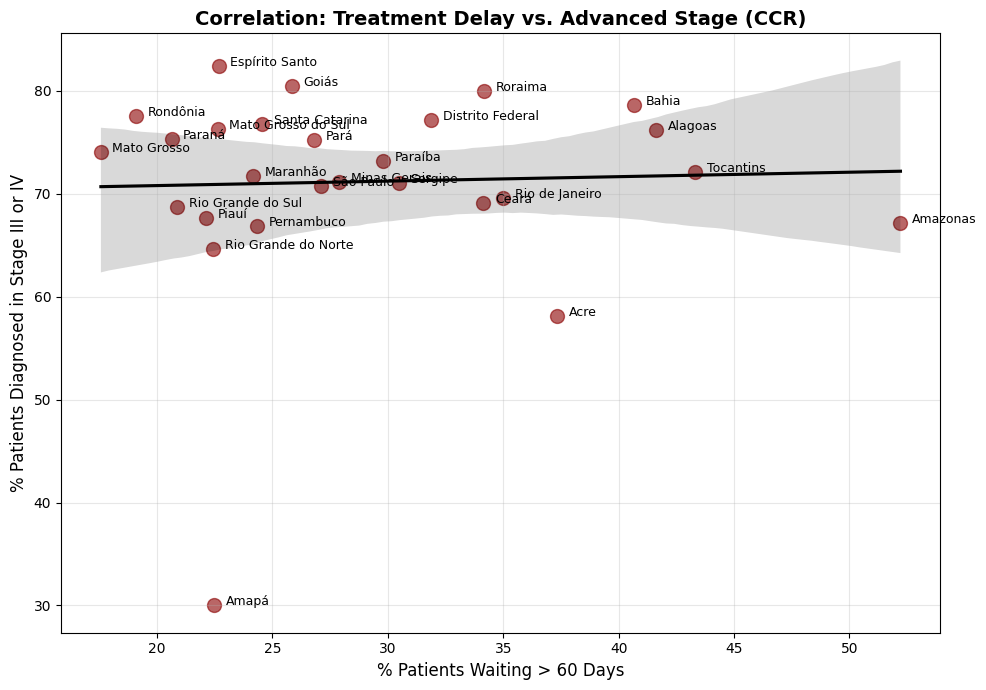

O coeficiente de correlação é: 0.04


In [4]:
# 1. Carregar o arquivo de Estadiamento
df_est = pd.read_csv('PAINEL_ONCOLOGIABR17697830524.csv', sep=';', encoding='latin1')

# 2. Ajustar nomes das colunas (0, 1, 2, 3, 4 são os estágios)
df_est.columns = ['UF_Raw', 'E0', 'E1', 'E2', 'E3', 'E4', 'NA', 'Total_Est']
df_est['UF'] = df_est['UF_Raw'].apply(clean_uf)

# 3. Calcular % de Estágio Avançado (III + IV)
# Convertemos para numérico por segurança
for col in ['E3', 'E4', 'Total_Est']:
    df_est[col] = pd.to_numeric(df_est[col], errors='coerce').fillna(0)

df_est['Percentual_Avancado'] = ((df_est['E3'] + df_est['E4']) / df_est['Total_Est']) * 100

# 4. Unir com a nossa tabela de Atraso que já criamos antes
final_boss = pd.merge(analise, df_est[['UF', 'Percentual_Avancado']], on='UF')

# 5. GRÁFICO DE CORRELAÇÃO (Scatter Plot)
plt.figure(figsize=(10, 7))
sns.regplot(x='Percentual_Atraso', y='Percentual_Avancado', data=final_boss,
            scatter_kws={'s':100, 'alpha':0.6, 'color':'darkred'}, line_kws={'color':'black'})

# Adicionar nomes das UFs nos pontos para saber quem é quem
for i in range(final_boss.shape[0]):
    plt.text(final_boss.Percentual_Atraso[i]+0.5, final_boss.Percentual_Avancado[i],
             final_boss.UF[i], fontsize=9)

plt.title('Correlation: Treatment Delay vs. Advanced Stage (CCR)', fontsize=14, fontweight='bold')
plt.xlabel('% Patients Waiting > 60 Days', fontsize=12)
plt.ylabel('% Patients Diagnosed in Stage III or IV', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular a correlação de Pearson (o número mágico da estatística)
corr = final_boss['Percentual_Atraso'].corr(final_boss['Percentual_Avancado'])
print(f"O coeficiente de correlação é: {corr:.2f}")

In [5]:
print(final_boss[['UF', 'Percentual_Atraso', 'Percentual_Avancado']])

                     UF  Percentual_Atraso  Percentual_Avancado
0              Amazonas          52.214022            67.137809
1             Tocantins          43.312102            72.058824
2               Alagoas          41.629630            76.156584
3                 Bahia          40.673212            78.620690
4                  Acre          37.349398            58.064516
5        Rio de Janeiro          34.990366            69.566814
6               Roraima          34.188034            80.000000
7                 Ceará          34.140802            69.068736
8      Distrito Federal          31.882771            77.158774
9               Sergipe          30.486009            71.014493
10              Paraíba          29.807692            73.185484
11         Minas Gerais          27.898042            71.133475
12            São Paulo          27.107589            70.776197
13                 Pará          26.804979            75.232198
14                Goiás          25.8353

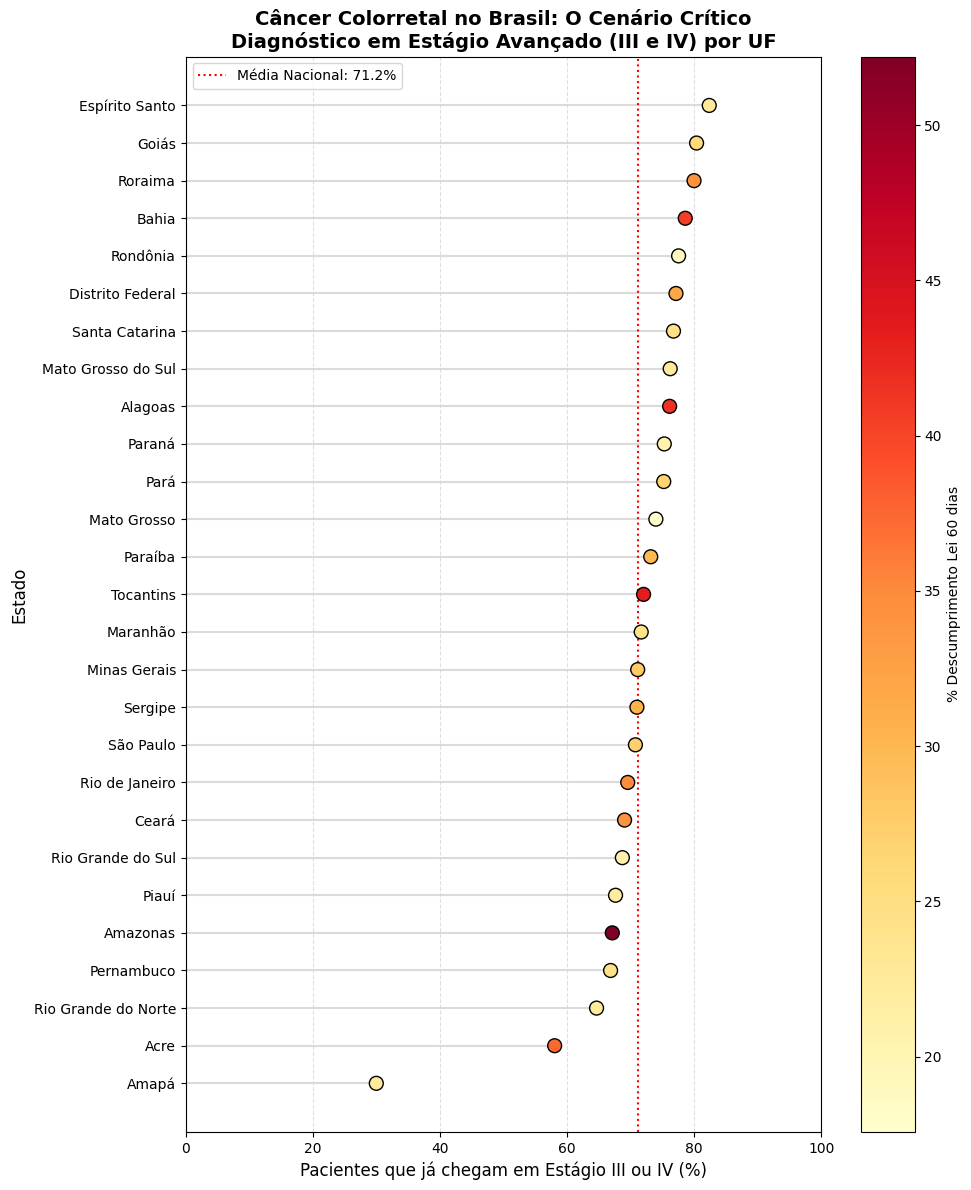

In [6]:
import matplotlib.pyplot as plt

df_plot = final_boss.sort_values('Percentual_Avancado', ascending=True)

plt.figure(figsize=(10, 12))
plt.hlines(y=df_plot['UF'], xmin=0, xmax=df_plot['Percentual_Avancado'], color='lightgrey', alpha=0.8)

# O ponto (pirulito) colorido pelo atraso
scatter = plt.scatter(df_plot['Percentual_Avancado'], df_plot['UF'],
                      c=df_plot['Percentual_Atraso'], cmap='YlOrRd', s=100, edgecolors='black', zorder=3)

plt.colorbar(scatter, label='% Descumprimento Lei 60 dias')
plt.title('Câncer Colorretal no Brasil: O Cenário Crítico\nDiagnóstico em Estágio Avançado (III e IV) por UF', fontsize=14, fontweight='bold')
plt.xlabel('Pacientes que já chegam em Estágio III ou IV (%)', fontsize=12)
plt.ylabel('Estado', fontsize=12)
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.4)

med_avanc = df_plot['Percentual_Avancado'].mean()
plt.axvline(med_avanc, color='red', linestyle=':', label=f'Média Nacional: {med_avanc:.1f}%')
plt.legend()

plt.tight_layout()
plt.show()